# Effective Stiffness of Composite Material

## Introduction

This example uses the homogenization pipeline to create a homogenization linkage for the effective stiffness. This example starts with a brief background of the homogenization theory on the components of the effective elastic stiffness tensor for a composite material. Then the example generates random microstructures and their average stress values that will be used to show how to calibrate and use our model. We will also show how to use tools from [sklearn](http://scikit-learn.org/stable/) to optimize fit parameters for the homogenization pipeline. Lastly, the data is used to evaluate the homogenization pipeline for effective stiffness values for a new set of microstructures.


## Linear Elasticity and Effective Elastic Modulus

For this example we are looking to create a homogenization linkage that predicts the effective isotropic stiffness components for two-phase microstructures. The specific stiffness component we are looking to predict in this example is $C_{xxxx}$ which is easily accessed by applying an uniaxial macroscal strain tensor (the only non-zero component is $\varepsilon_{xx}$). 

$$ u(L, y) = u(0, y) + L\bar{\varepsilon}_{xx}$$

$$ u(0, L) = u(0, 0) = 0  $$

$$ u(x, 0) = u(x, L) $$

More details about these boundary conditions can be found in [1]. Using these boundary conditions, $C_{xxxx}$ can be estimated calculating the ratio of the averaged stress over the applied averaged strain.

$$ C_{xxxx}^* \cong  \bar{\sigma}_{xx} / \bar{\varepsilon}_{xx}$$ 

In this example, $C_{xxxx}$ for 6 different types of microstructures will be estimated, using the `Homogenization Pipeline`, and provides a method to compute $\bar{\sigma}_{xx}$ for a new microstructure with an applied strain of $\bar{\varepsilon}_{xx}$.


In [1]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointcorrelation,FlattenTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from pymks.datasets import make_elastic_stress_random
from toolz.curried import groupby, get, pipe, valmap, merge_with, merge, valmap, pluck
from toolz.curried import map as map_
from pymks.fmks.func import sequence


## Data Generation

A set of periodic microstructures and their volume averaged elastic stress values $\bar{\sigma}_{xx}$ can be generated by importing the `make_elastic_stress_random` function from `pymks.datasets`. This function has several arguments. `n_samples` is the number of samples that will be generated, `size` specifies the dimensions of the microstructures, `grain_size` controls the effective microstructure feature size, `elastic_modulus` and `poissons_ratio` are used to indicate the material property for each of the
phases, `macro_strain` is the value of the applied uniaxial strain, and the `seed` can be used to change the the random number generator seed.

Let's go ahead and create 6 different types of microstructures each with 200 samples with dimensions 21 x 21. Each of the 6 samples will have a different microstructure feature size. The function will return and the microstructures and their associated volume averaged stress values.


In [2]:
sample_size = 200
grain_size = [(15, 2), (2, 15), (7, 7), (8, 3), (3, 9), (2, 2)]
n_samples = [sample_size] * 6
elastic_modulus = (310, 200)
poissons_ratio = (0.28, 0.3)
macro_strain = 0.001
size = (21, 21)

X, y = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size, 
                                      elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio, 
                                      macro_strain=macro_strain, seed=0)


The array `X` contains the microstructure information and has the dimensions 
of `(n_samples, Nx, Ny)`. The array `y` contains the average stress value for 
each of the microstructures and has dimensions of `(n_samples,)`.


In [3]:
print(X.shape)
print(y.shape)


(1200, 21, 21)
(1200,)


Lets take a look at the 6 types the microstructures to get an idea of what they 
look like. We can do this by importing `draw_microstructures`. 


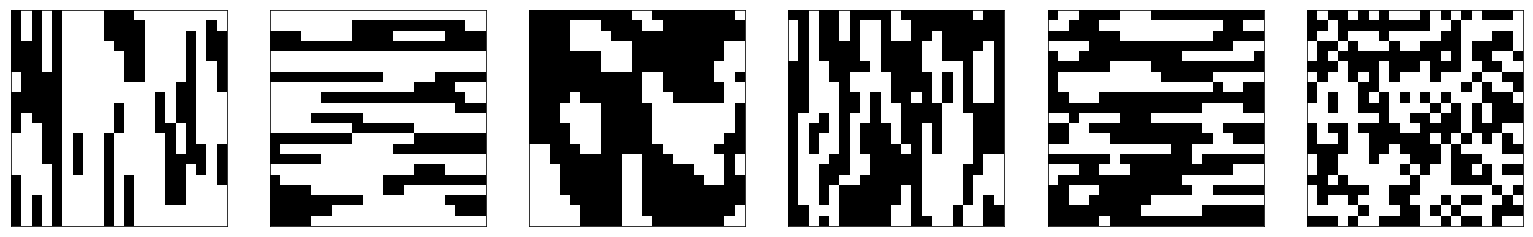

In [4]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
X_examples = X[::sample_size]

fig, axs = plt.subplots(1, X_examples.shape[0], figsize=(4 * X_examples.shape[0], 4))
fig.subplots_adjust(right=1)
def plot_binary(arrs,ax):
    ax.set_xticks(())
    ax.set_yticks(())   
    return ax.imshow(arrs,cmap='gray')

for x in range(X_examples.shape[0]):
    plot_binary(X_examples[x],axs[x])

In this dataset 4 of the 6  microstructure types have grains that are elongated in either
the x or y directions. The remaining 2 types of samples have equiaxed grains with
different average sizes.

Let's look at the stress values for each of the microstructures shown above.


In [5]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Stress Values', y[::200])

Stress Values [0.23667242 0.23284418 0.26548572 0.25849173 0.25648683 0.24744216]


Now that we have a dataset to work with, we can look at how to use the `Homogenization pipeline`to predict stress values for new microstructures.


## Homogenization Pipeline Work Flow

The homogenization pipeline presented in this notebook takes in a dataset and 
 - calculates the 2-point statistics  
 - performs [dimensionality reduction](http://en.wikipedia.org/wiki/Dimensionality_reduction) using [Prinicple Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA)  
 - and fits a [polynomial regression model](http://en.wikipedia.org/wiki/Polynomial_regression) model to the low-dimensional representation.  

This work flow has been shown to accurately predict effective properties in several examples [2][3], and requires that we specify the number of components used in dimensionality reduction and the order of the polynomial we will be using for the polynomial regression. In this example we will show how we can use tools from [sklearn](http://scikit-learn.org/stable/) to try and optimize our selection for these two parameters.


## Modeling with Homogenization Pipeline

To create the homogenization pipeline, we need to define the steps that will be used for homogenization framework. For this particular example, there are only 2 discrete phases, so we will use the `PrimitiveTransformer` from `PyMKS` to discretize the microstructure. We only have two phases denoted by 0 and 1, therefore we have two local states and our domain is 0 to 1. Then, we will obtain the statistical representation of the discretized microstructures by utilizing `TwoPointcorrelation`.Then, we will flatten the 2-dimensional statistical representation to 1 dimension, and utilize PCA joined with polynomial regression to develop a structure-property linkage between calculated properties and microstructures. More details about the homogenization framework can be found from cited articles [2-3].

Let's create the homogenization pipeline (`bl`).


In [6]:
bl=Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointcorrelation(periodic_boundary=True, cutoff=21,correlations=[(1,1),(0,0)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA()),
    ('poly', PolynomialFeatures()),
    ('connector', LinearRegression())
])

## Optimizing the Number of Components and Polynomial Order

To start with, we can look at how the variance changes as a function of the number of components.
In general for SVD as well as PCA, the amount of variance captured in each component decreases
as the component number increases.
This means that as the number of components used in the dimensionality reduction increases, the percentage of the variance will asymptotically approach 100%. Let's see if this is true for our dataset.

To just visualize this, we will create the `PCA_pipeline` that will get the data (microstructures) ready for principal component analysis. Then, we will utilize `sklearn` `PCA` function to perform dimensionality reduction and visualize the explained percentage of variance with respect to the number of PC components.

Note that this pipeline (`PCA_pipeline`) is just to obtain the results for dimensionality reduction. Homogenization pipeline(`bl`) explained above already performs this operation while building the homogenization linkage. This visualization is a good example that PyMKS users can control every step of the homogenization workflow by adjusting the pipeline.

In [7]:
PCA_pipeline=Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointcorrelation(periodic_boundary=True, cutoff=21,correlations=[(0,0),(1,1)])),
    ('flatten', FlattenTransformer())])

In [8]:
A=PCA_pipeline.fit(X).transform(X)
pca=PCA(n_components=40)
pca.fit(A)
variance=pca.explained_variance_ratio_
n_components = len(variance)

Now look at how the cumlative variance changes as a function of the number of components using `draw_component_variance` 
from `pymks.tools`.


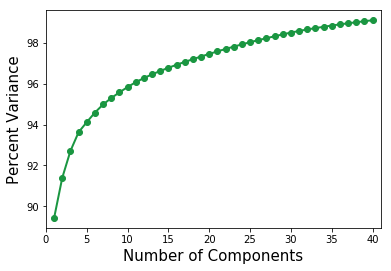

In [9]:
x = np.arange(1, n_components + 1)
plt.plot(x, np.cumsum(variance * 100), 'o-', color='#1a9641', linewidth=2)
plt.xlabel('Number of Components', fontsize=15)
plt.xlim(0, n_components + 1)
plt.ylabel('Percent Variance', fontsize=15)
plt.show()

Roughly 93 percent of the variance is captured with the first 5 components. This means our model may only need a few components to predict the average stress.

Next we need to optimize the number of components and the polynomial order. To do this we are going to split the data into test and training sets. This can be done using the [train_test_spilt](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function from `sklearn`.


In [10]:
flat_shape = (X.shape[0],) + (X[0].size,)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(flat_shape), y,
                                                    test_size=0.2, random_state=3)
print(X_train.shape)
print(X_test.shape)


(960, 441)
(240, 441)


We will use cross validation with the testing data to fit a number 
of models, each with a different number 
of components and a different polynomial order.
Then we will use the testing data to verify the best model. 
This can be done using [GridSeachCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) 
from sklearn.

We will pass a dictionary `params_to_tune` with the range of polynomial order `degree` and components `n_components` we want to try. 


Let's vary `n_components` from 1 to 11 and `degree` from 1 to 3.


In [11]:
params_to_tune = {'reducer__n_components': np.arange(1, 12),'poly__degree': np.arange(1, 4)}
gs = GridSearchCV(bl, params_to_tune).fit(X_train, y_train)


Let's look at the how the mean [R-squared](http://en.wikipedia.org/wiki/Coefficient_of_determination) values and their 
standard deviations change, as we varied the number of `n_components` and `degree`.

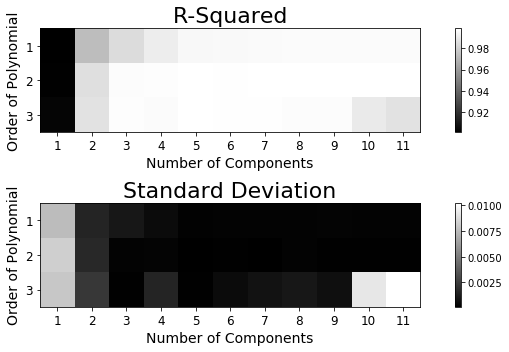

In [12]:
grid_scores=gs
params=['reducer__n_components', 'poly__degree']
param_labels=['Number of Components', 'Order of Polynomial']
score_label='R-Squared'

param = grid_scores.cv_results_['params']
means = grid_scores.cv_results_['mean_test_score']
stddev = grid_scores.cv_results_['std_test_score']

param_range_0 = grid_scores.param_grid[params[0]]
param_range_1 = grid_scores.param_grid[params[1]]
mat_size = (len(param_range_1), len(param_range_0))
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
matrices = np.concatenate((np.array(means).reshape(mat_size)[None],
                           np.array(stddev).reshape(mat_size)[None]))
# X_cmap = _grid_matrix_cmap()
x_label = param_labels[0]
y_label = param_labels[1]
plot_title = [score_label, 'Standard Deviation']
for ax, label, matrix, title in zip(axs, param_labels,
                                    matrices,
                                    plot_title):
    ax.set_xticklabels(param_range_0, fontsize=12)
    ax.set_yticklabels(param_range_1, fontsize=12)
    ax.set_xticks(np.arange(len(param_range_0)))
    ax.set_yticks(np.arange(len(param_range_0)))
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.grid(False)
    im = ax.imshow(matrix, cmap='gray',interpolation='none')
    ax.set_title(title, fontsize=22)
    cbar = plt.colorbar(im, ax=ax)

    fig.subplots_adjust(right=1.2)
plt.tight_layout()
plt.show()

It looks like we get a poor fit, when only the first and second component are used, and when we increase
the polynomial order and the components together. The models have a high standard deviation and 
poor R-squared values for both of these cases.

There seems to be several potential models that use 4 to 11 components, but it's difficult to see which model 
is the best. Let's use our test data `X_test` to see which model performs the best.


In [13]:
print('Order of Polynomial',gs.best_params_.get('poly__degree'))
print('Number of Components', gs.best_params_.get('reducer__n_components'))
# print('R-squared Value', np.allclose(gs.score(X_test, y_test), 1, rtol=1e-2))
assert gs.best_params_.get('reducer__n_components') in (9, 10)

Order of Polynomial 2
Number of Components 9


For the parameter range that we searched, we have found that a model with 2nd order polynomial 
and 9 components had the best R-squared value. Let's look at the same values, using R-squared vs Number of PC components plot.


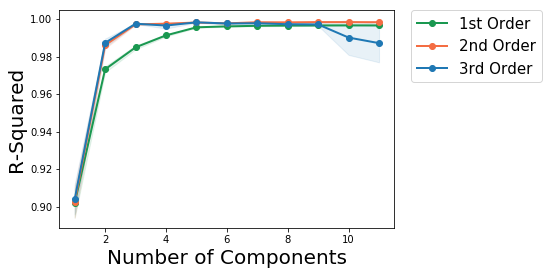

In [14]:
def compute(data):
    """Compute the component, error and standard deviation arrays from a grouped
    grid score.
    """
    pluck_ = lambda x: list(pluck(x, data))
    return dict(
        std_dev=pluck_('std_test_score'),
        mean=np.array(pluck_('mean_test_score')),
        x=pluck_('param_reducer__n_components')
    )

def munge(data, plot_data):
    """Compute the data for plotting from the grid scores
    """
    return pipe(
        data,
        groupby(lambda x: x['params']['poly__degree']),
        valmap(compute),
        lambda x: merge_with(merge, plot_data, x)
    )

def plot_line(x, mean, std_dev, color, label):
    plt.fill_between(x, mean - std_dev, mean + std_dev, alpha=0.1, color=color)
    plt.plot(x, mean, 'o-', color=color, label=label, linewidth=2)
    

def plot(grid_scores, plot_data):
    valmap(lambda x: plot_line(**x), munge(grid_scores, plot_data))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    plt.ticklabel_format(style='sci', axis='y')
    plt.ylabel('R-Squared', fontsize=20)
    plt.xlabel('Number of Components', fontsize=20)
    plt.show()
    
plot(
    pandas.DataFrame(gs.cv_results_).to_dict('records'),
    {
        1: dict(label='1st Order', color='#1a9850'),
        2: dict(label='2nd Order', color='#f46d43'),
        3: dict(label='3rd Order', color='#1f78b4')
    }
)

As we said, a model with a 2rd order polynomial and 9 components will give us the best result. Let's use the
best model from our grid scores.


In [15]:
model = gs.best_estimator_


## Prediction using Homogenization Pipeline

Now that we have selected values for `n_components` and `degree`, lets fit the model with the data.

In [16]:
model.fit(X, y)


Pipeline(memory=None,
     steps=[('discritize', PrimitiveTransformer(chunks=None, max_=1.0, min_=0.0, n_state=2)), ('Correlations', TwoPointcorrelation(correlations=[(1, 1), (0, 0)], cutoff=21,
          periodic_boundary=True)), ('flatten', FlattenTransformer()), ('reducer', PCA(copy=True, iterated_power='auto', n_component...nnector', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

Let's generate some more data that can be used to try and validate our model's prediction accuracy. We are going to
generate 20 samples of all six different types of microstructures using the same 
`make_elastic_stress_random` function.


In [17]:
test_sample_size = 20
n_samples = [test_sample_size] * 6
X_new, y_new = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size, 
                                          elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio, 
                                          macro_strain=macro_strain, seed=1)


Now let's predict the stress values for the new microstructures. 


In [18]:
y_predict = model.predict(X_new)


We can check if the low-dimensional representation of the 
new data is similar to the low-dimensional representation of the train data by visualizing the microstructures in PC space.


In [19]:
PCA_pipeline=Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointcorrelation(periodic_boundary=True, cutoff=21,correlations=[(1,1),(0,0)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])


In [20]:
A=PCA_pipeline.fit(X_train).transform(X_train)
B=PCA_pipeline.transform(X_test)

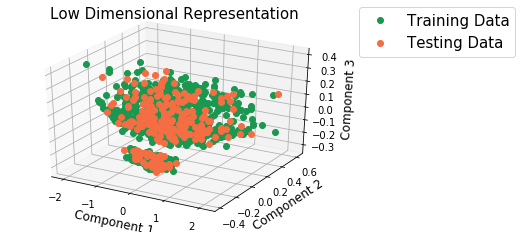

In [21]:
from mpl_toolkits.mplot3d import Axes3D
title = 'Low Dimensional Representation'
data=[A[:, :3],B[:, :3]]
X_array = np.concatenate(data)
component_labels = range(1,4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Component ' + str(component_labels[0]), fontsize=12)
ax.set_ylabel('Component ' + str(component_labels[1]), fontsize=12)
ax.set_zlabel('Component ' + str(component_labels[2]), fontsize=12)
x_min, x_max = [np.min(X_array[:, 0]), np.max(X_array[:, 0])]
y_min, y_max = [np.min(X_array[:, 1]), np.max(X_array[:, 1])]
z_min, z_max = [np.min(X_array[:, 2]), np.max(X_array[:, 2])]
x_epsilon = (x_max - x_min) * 0.05
y_epsilon = (y_max - y_min) * 0.05
z_epsilon = (z_max - z_min) * 0.05
ax.set_xlim([x_min - x_epsilon, x_max + x_epsilon])
ax.set_ylim([y_min - y_epsilon, y_max + y_epsilon])
ax.set_zlim([z_min - z_epsilon, z_max + z_epsilon])
labels=['Training Data', 'Testing Data']
colors=['#1a9850','#f46d43']
for label, pts,colors in zip(labels, data,colors):
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], 'o', label=label,color=colors)
plt.title(title, fontsize=15)
# ax.view_init(132, 0)
lg = plt.legend(loc=1, borderaxespad=0., fontsize=15)
lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2,borderaxespad=0., fontsize=15)
plt.show()

The predicted data seems to be reasonably similar to the data we used to fit the model
with. Now let's look at the score value for the predicted data.


In [22]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
assert (np.allclose(model.score(X_new, y_new), 1, rtol=1e-2))
print("R-squared %.4f" % model.score(X_new, y_new))

R-squared 0.9996


Looks pretty good. Let's print out one actual and predicted stress value for each of the 6 microstructure types to see how they compare.


In [23]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Actual Stress   ', y_new[::20])
print('Predicted Stress', y_predict[::20])

Actual Stress    [0.2530431  0.22299453 0.25053209 0.24884992 0.24404828 0.24893845]
Predicted Stress [0.25308206 0.22329536 0.25087914 0.248583   0.24396659 0.24879218]


Lastly, we can also evaluate our prediction by looking at a goodness-of-fit plot. 


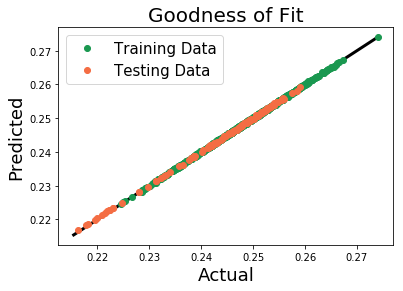

In [24]:

fit_data = np.array([y, model.predict(X)])
pred_data = np.array([y_new, y_predict])
y_total = np.concatenate((fit_data, pred_data), axis=-1)
y_min, y_max = np.min(y_total), np.max(y_total)
middle = (y_max + y_min) / 2.
data_range = y_max - y_min
line = np.linspace(middle - data_range * 1.03 / 2,
                   middle + data_range * 1.03 / 2, endpoint=False)
plt.plot(line, line, '-', linewidth=3, color='#000000')
plt.plot(fit_data[0], fit_data[1], 'o', color='#1a9850', label=labels[0])
plt.plot(pred_data[0], pred_data[1], 'o',
         color='#f46d43', label=labels[1])
plt.title('Goodness of Fit', fontsize=20)
plt.xlabel('Actual', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.legend(loc=2, fontsize=15)
plt.show()

We can see that the `Homogenization Pipeline` has created a homogenization linkage for the effective stiffness for the 6 different microstructures and has predicted the average stress values for our new microstructures reasonably well.


## References

[1] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

[2] Çeçen, A., et al. "A data-driven approach to establishing microstructure–property relationships in porous transport layers of polymer electrolyte fuel cells." Journal of Power Sources 245 (2014): 144-153. [doi:10.1016/j.jpowsour.2013.06.100](http://dx.doi.org/10.1016/j.jpowsour.2013.06.100)

[3] Deshpande, P. D., et al. "Application of Statistical and Machine Learning Techniques for Correlating Properties to Composition and Manufacturing Processes of Steels." 2 World Congress on Integrated Computational Materials Engineering. John Wiley & Sons, Inc.  [doi:10.1002/9781118767061.ch25](http://dx.doi.org/10.1002/9781118767061.ch25)
